In [3]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [5]:
from medvqa.utils.files import load_pickle

import medvqa
from importlib import reload

In [24]:
!python ../scripts/mscxr/precompute_phrase_embeddings.py \
--model_name "microsoft/BiomedVLP-CXR-BERT-specialized" \
--model_checkpoint_folder_path \
"/mnt/data/pamessina/workspaces/medvqa-workspace/models/fact_embedding/20240207_184445_MIMIC-CXR(triplets+classif+entcont+nli+radgraph+autoencoder)_FactEncoder(microsoft-BiomedVLP-CXR-BERT-specialized)"

len(phrases): 715
Obtaining embeddings for each phrase...
checkpoint_names = ['checkpoint_91_cacc+chf1+chf1+cscc+encc+hscc+nlcc+sass+spss+ta0)+ta1)+ta2)+ta0)+ta1)+ta2)+ta3)+ta4)+ta5)+ta6)+ta7)=0.9337.pt']
  0%|                                                   | 0/715 [00:00<?, ?it/s]Loading cached text embeddings from /mnt/workspace/pamessina/medvqa-workspace/cache/text_embeddings_cache(hash=440,3465006188639683439).pkl
len(self.cache["hashes"]) = 4766841
self.cache["embeddings"].shape = (4766841, 128)
100%|████████████████████████████████████████| 715/715 [00:06<00:00, 106.17it/s]
Computing embeddings for 513 new texts
checkpoint_names = ['checkpoint_91_cacc+chf1+chf1+cscc+encc+hscc+nlcc+sass+spss+ta0)+ta1)+ta2)+ta0)+ta1)+ta2)+ta3)+ta4)+ta5)+ta6)+ta7)=0.9337.pt']
Loading model weights from /mnt/data/pamessina/workspaces/medvqa-workspace/models/fact_embedding/20240207_184445_MIMIC-CXR(triplets+classif+entcont+nli+radgraph+autoencoder)_FactEncoder(microsoft-BiomedVLP-CXR-BERT-specializ

In [14]:
phrase2embedding = load_pickle('/mnt/workspace/pamessina/medvqa-workspace/cache/mimiccxr/mscxr_phrase2embedding(hash=36521,3206715123524916204).pkl')

# 1) Phrase Grounding: DenseNet121 + CXRFE + Sigmoid-based attention

In [43]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240618_175951_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,SigmoidAttention,128,256,256,1)" \
--max_images_per_batch 100 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--mscxr_phrase2embedding_filepath \
"/mnt/workspace/pamessina/medvqa-workspace/cache/mimiccxr/mscxr_phrase2embedding(hash=36521,3206715123524916204).pkl" \
--eval_mscxr

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240618_175951_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,SigmoidAttention,128,256,256,1)
   max_images_per_batch: 100
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: /mnt/workspace/pamessina/medvqa-workspace/cache/mimiccxr/mscxr_phrase2embedding(hash=36521,3206715123524916204).pkl
   eval_chest_imagenome_gold: False
   eval_mscxr: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240618_175951_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,SigmoidAttention,128,256,256,1)/metadata.json
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of PhraseGrounder ...
MultiPurposeVisualModule()
  Initializing raw

In [94]:
tmp1 = load_pickle('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20240618_175951_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,SigmoidAttention,128,256,256,1)/mscxr_metrics.pkl')

In [188]:
tmp = tmp1

In [189]:
tmp.keys()

dict_keys(['image_paths', 'phrases', 'pred_masks', 'gt_masks', 'ious', 'pg_segmask_iou'])

In [159]:
import numpy as np

In [160]:
idxs = np.argsort(tmp['ious'])[::-1]

In [161]:
for i in range(10):
    print(tmp['ious'][idxs[i]], tmp['phrases'][idxs[i]])

0.9222196936607361 cardiac silhouette is mildly enlarged
0.9011855125427246 cardiomegaly is present
0.9001855850219727 cardiomegaly noted
0.8986737132072449 cardiac silhouette is enlarged
0.8986091017723083 enlarged cardiac silhouette noted
0.8967530727386475 bilateral, diffuse lung consolidation is present, consistent with acute lung injury edema
0.8966353535652161 markedly enlarged cardiac silhouette
0.8940171003341675 mild cardiomegaly is present
0.8929531574249268 moderate cardiomegaly is present
0.8925387263298035 cardiac silhouette is enlarged


In [162]:
for i in range(-1, -11, -1):
    print(tmp['ious'][idxs[i]], tmp['phrases'][idxs[i]])

4.763368997373618e-05 Small left pneumothorax has increased
0.003397588385269046 loculated basilar hydropneumothorax
0.008356072008609772 there is a small right apical pneumothorax
0.00929185375571251 New focal haziness in the left lung base
0.011499735526740551 mild patchy consolidation in the right infrahilar lung
0.01461635623127222 Minimal residual right middle lobe opacity, otherwise clear lungs
0.0783521980047226 decreasing pneumonia
0.08523338288068771 small right apical pneumothorax
0.08659204840660095 Focal opacity in the lingula
0.0981958881020546 there is a left chest tube and small basilar left pneumothorax


In [173]:
reload(medvqa.utils.logging)
reload(medvqa.evaluation.plots)

<module 'medvqa.evaluation.plots' from '/home/pamessina/medvqa/medvqa/evaluation/plots.py'>

In [174]:
from medvqa.evaluation.plots import (
    plot_embeddings_sentences_and_scores,
    plot_segmentation_mask_area_vs_iou,
    plot_wordclouds_per_bin,
    visualize_attention_maps,
)
from medvqa.datasets.ms_cxr import PhraseGroundingAnnotationsVisualizer

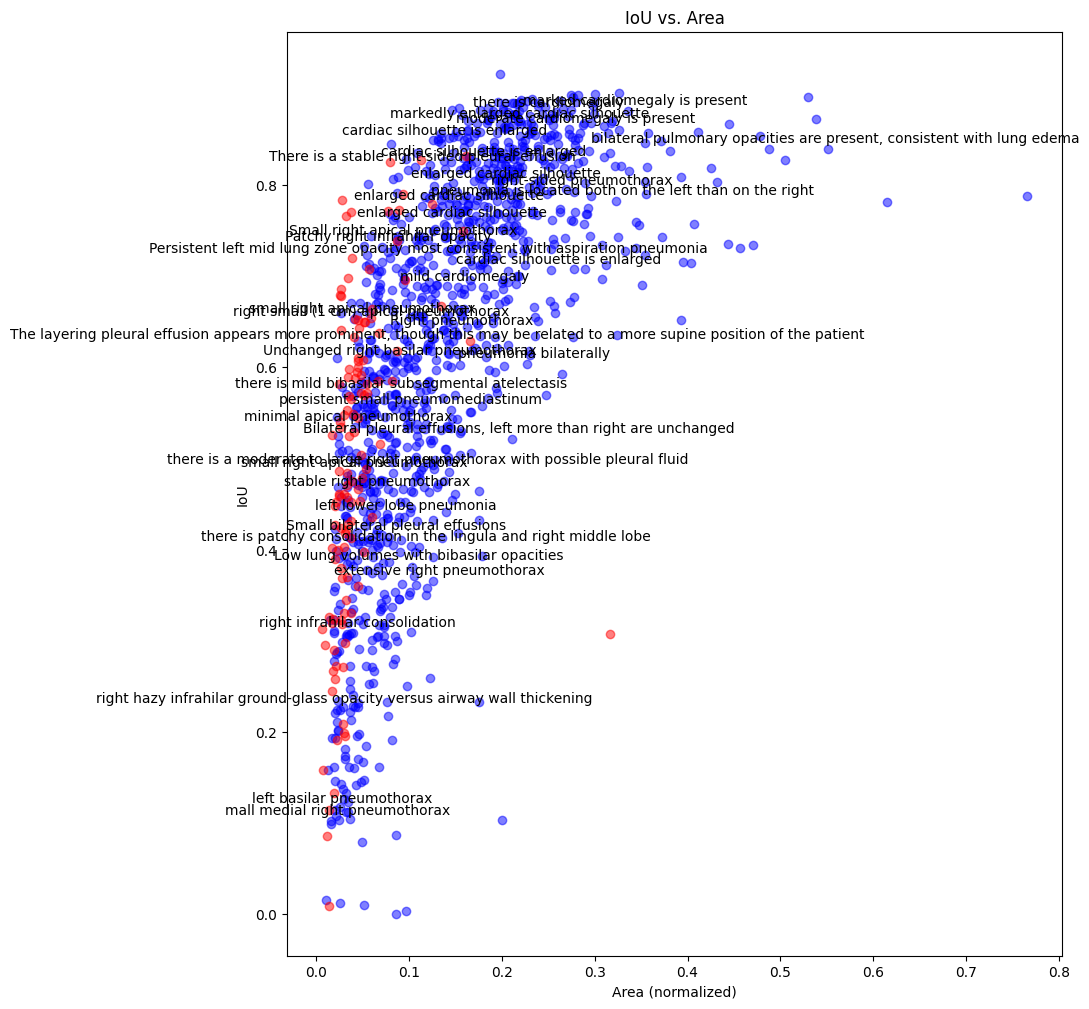

(IoU=0.881, area=0.336, idx=478) marked cardiomegaly is present
(IoU=0.878, area=0.243, idx=499) there is cardiomegaly
(IoU=0.866, area=0.212, idx=534) markedly enlarged cardiac silhouette
(IoU=0.861, area=0.272, idx=755) moderate cardiomegaly is present
(IoU=0.848, area=0.131, idx=668) cardiac silhouette is enlarged
(IoU=0.839, area=0.551, idx=363) bilateral pulmonary opacities are present, consistent with lung edema
(IoU=0.825, area=0.173, idx=526) cardiac silhouette is enlarged
(IoU=0.820, area=0.107, idx=928) There is a stable right-sided pleural effusion
(IoU=0.800, area=0.197, idx=649) enlarged cardiac silhouette
(IoU=0.793, area=0.278, idx=291) right-sided pneumothorax
(IoU=0.782, area=0.323, idx=167) pneumonia is located both on the left than on the right
(IoU=0.777, area=0.136, idx=158) enlarged cardiac silhouette
(IoU=0.758, area=0.139, idx=142) enlarged cardiac silhouette
(IoU=0.739, area=0.087, idx=161) Small right apical pneumothorax
(IoU=0.732, area=0.071, idx=356) Patchy

In [165]:
plot_segmentation_mask_area_vs_iou(
    masks_array=tmp['gt_masks'],
    iou_array=tmp['ious'],
    normalize_area=True,
    sentences=tmp['phrases'],
    num_annotations=40,
    figsize=(10, 12),
    highlight_points_with_sentences_containing='apical'
)

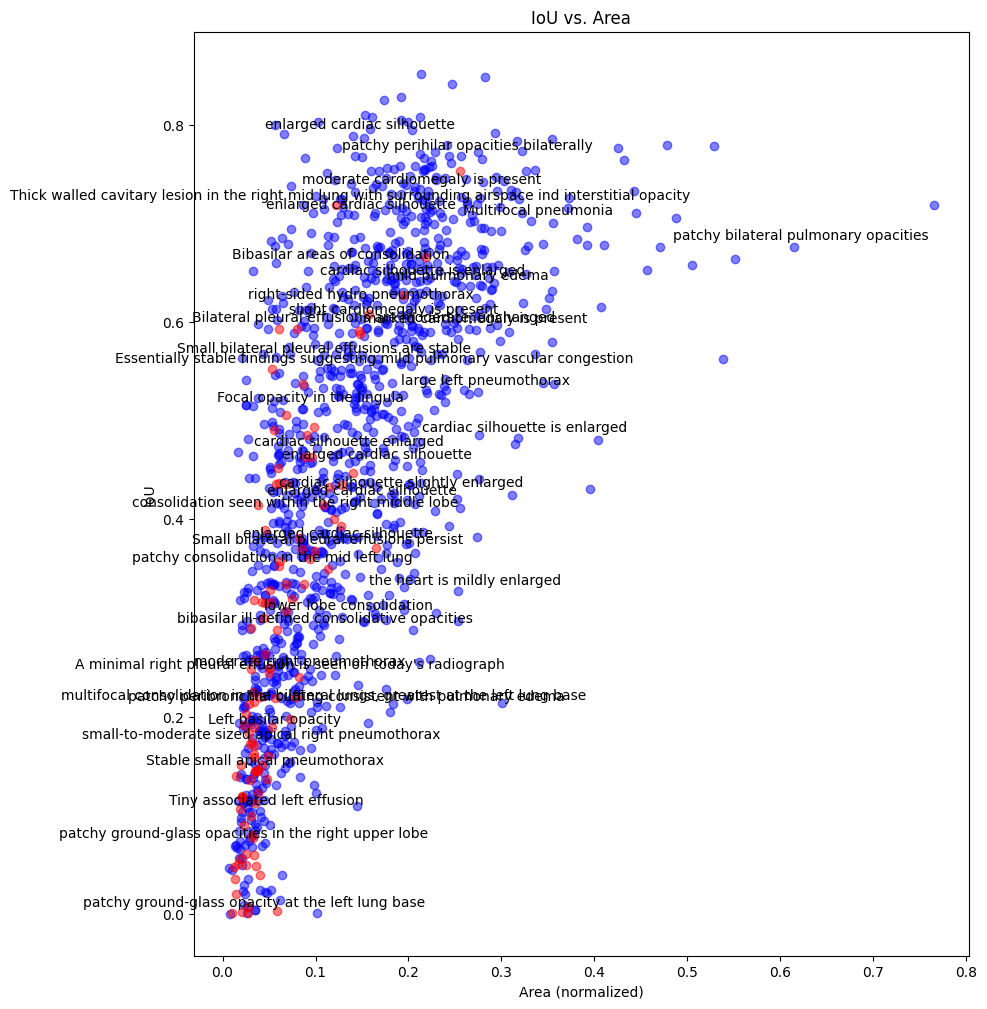

(IoU=0.789, area=0.140, idx=569) enlarged cardiac silhouette
(IoU=0.768, area=0.256, idx=512) patchy perihilar opacities bilaterally
(IoU=0.733, area=0.206, idx=431) moderate cardiomegaly is present
(IoU=0.717, area=0.130, idx=34) Thick walled cavitary lesion in the right mid lung with surrounding airspace ind interstitial opacity
(IoU=0.708, area=0.142, idx=385) enlarged cardiac silhouette
(IoU=0.702, area=0.332, idx=360) Multifocal pneumonia
(IoU=0.676, area=0.614, idx=282) patchy bilateral pulmonary opacities
(IoU=0.657, area=0.120, idx=66) Bibasilar areas of consolidation
(IoU=0.641, area=0.208, idx=464) cardiac silhouette is enlarged
(IoU=0.636, area=0.257, idx=780) mild pulmonary edema
(IoU=0.617, area=0.141, idx=205) right-sided hydro pneumothorax
(IoU=0.602, area=0.176, idx=904) slight cardiomegaly is present
(IoU=0.594, area=0.155, idx=704) Bilateral pleural effusions are moderate, unchanged
(IoU=0.593, area=0.265, idx=650) marked cardiomegaly is present
(IoU=0.562, area=0.102

In [187]:
plot_segmentation_mask_area_vs_iou(
    masks_array=tmp['gt_masks'],
    iou_array=tmp['ious'],
    normalize_area=True,
    sentences=tmp['phrases'],
    num_annotations=40,
    figsize=(10, 12),
    highlight_points_with_sentences_containing='small'
)

==================== Bin 1 (0.000-0.231)


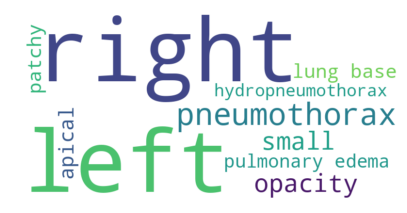

==================== Bin 2 (0.231-0.461)


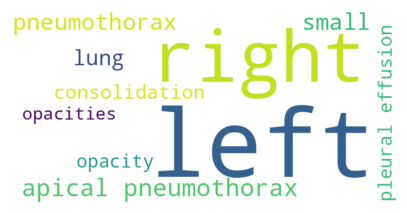

==================== Bin 3 (0.461-0.692)


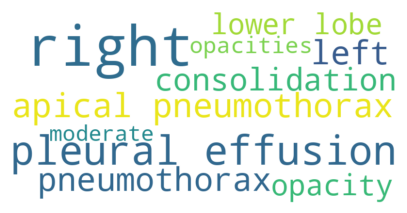

==================== Bin 4 (0.692-0.922)


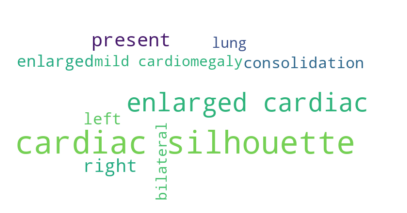

In [166]:
plot_wordclouds_per_bin(
    sentences=tmp['phrases'],
    scores=tmp['ious'],
    num_bins=4,
    figsize=(5,5),
    num_words=10
)

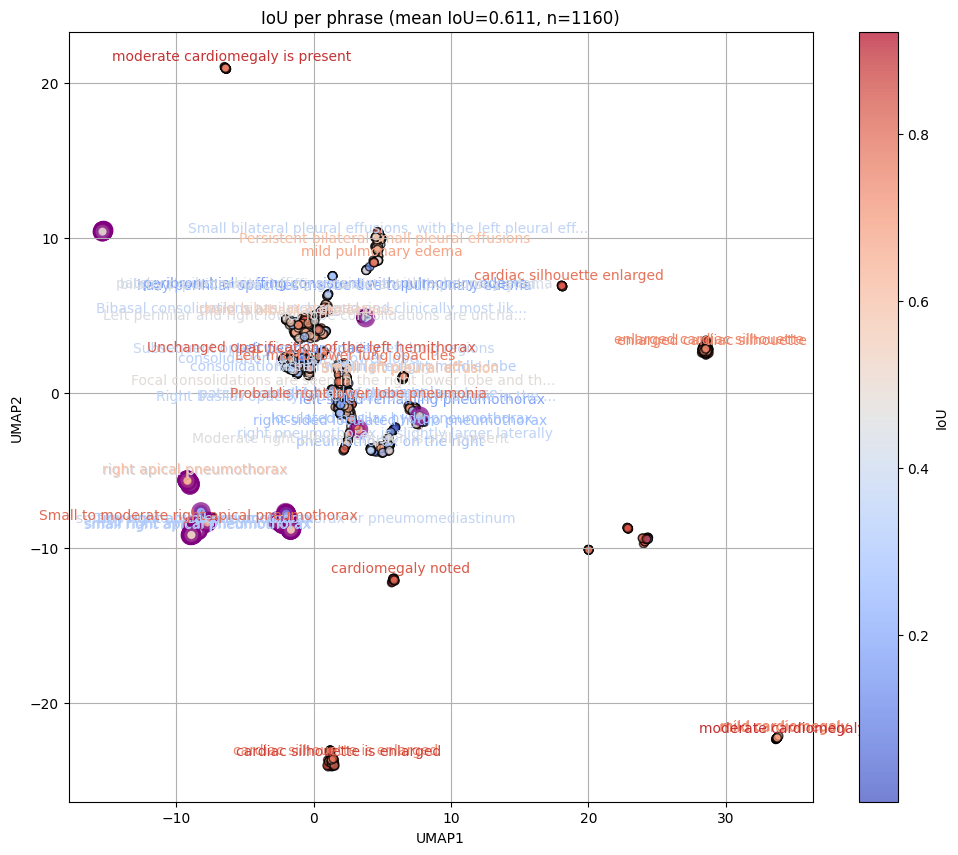

moderate cardiomegaly (0.885, idx=566)
moderate cardiomegaly is present (0.876, idx=605)
cardiac silhouette is enlarged (0.856, idx=816)
Unchanged opacification of the left hemithorax (0.815, idx=595)
cardiomegaly noted (0.815, idx=477)
Probable right lower lobe pneumonia (0.791, idx=346)
Small to moderate right apical pneumothorax (0.791, idx=339)
cardiac silhouette enlarged (0.772, idx=639)
Left mid-to-lower lung opacities (0.762, idx=197)
mild cardiomegaly (0.748, idx=519)
enlarged cardiac silhouette (0.739, idx=561)
enlarged cardiac silhouette (0.730, idx=859)
cardiac silhouette is enlarged (0.730, idx=1073)
mild cardiomegaly (0.708, idx=420)
mild pulmonary edema (0.667, idx=780)
Persistent bilateral small pleural effusions (0.599, idx=216)
right apical pneumothorax (0.589, idx=295)
Small left pleural effusion (0.569, idx=370)
Small left pleural effusion (0.560, idx=451)
there is bibasilar atelectasis (0.536, idx=688)
mild bibasilar atelectasis (0.527, idx=1085)
Focal consolidation

In [176]:
plot_embeddings_sentences_and_scores(
    embeddings=[phrase2embedding[x] for x in tmp['phrases']],
    sentences=tmp['phrases'],
    scores=tmp['ious'],
    title='IoU per phrase',
    score_name='IoU',
    num_annotations=50,
    figsize=(12, 10),
    sentence_max_length=60,
    sample_more_from_low_scores=True,
    highlight_points_with_sentences_containing='apical',
    use_umap=True,
)

In [18]:
pgav = PhraseGroundingAnnotationsVisualizer()

In [16]:
# i = -1
# idx = idxs[i]
idx = 236
print(tmp['ious'][idx])
print()
print(tmp['image_paths'][idx])
print()
print(tmp['phrases'][idx])

dicom_id = tmp['image_paths'][idx].split('/')[-1].split('.')[0]

0.5528247356414795

/mnt/workspace/mimic-cxr-jpg/images-medium(512)/p10/p10550799/s51294166/021cf26b-cd5779dd-8a839d8a-92ede30b-41c1f997.jpg

Bibasilar consolidations appear slightly worse, particularly on the right. This is consistent with multifocal pneumonia


Found 2 rows for dicom_id 021cf26b-cd5779dd-8a839d8a-92ede30b-41c1f997
Image path: /mnt/data/mimic-cxr-jpg/images/p10/p10550799/s51294166/021cf26b-cd5779dd-8a839d8a-92ede30b-41c1f997.jpg
Label text: Bibasilar consolidations appear slightly worse, particularly on the right. This is consistent with multifocal pneumonia
Category name: Pneumonia
x: 428, y: 1763, w: 679, h: 616
Label text: Bibasilar consolidations appear slightly worse, particularly on the right. This is consistent with multifocal pneumonia
Category name: Pneumonia
x: 1370, y: 1810, w: 683, h: 632


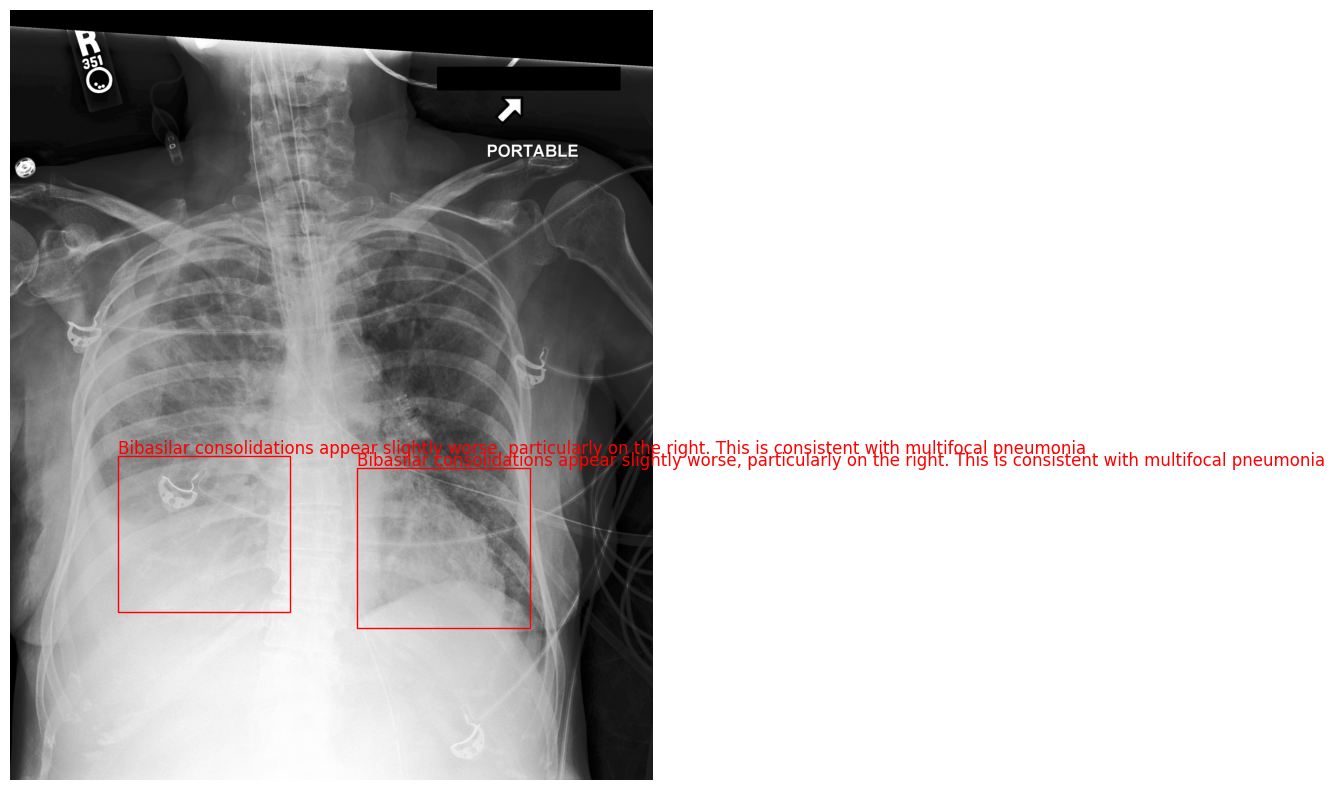

In [19]:
pgav.visualize_dicom_id(dicom_id)

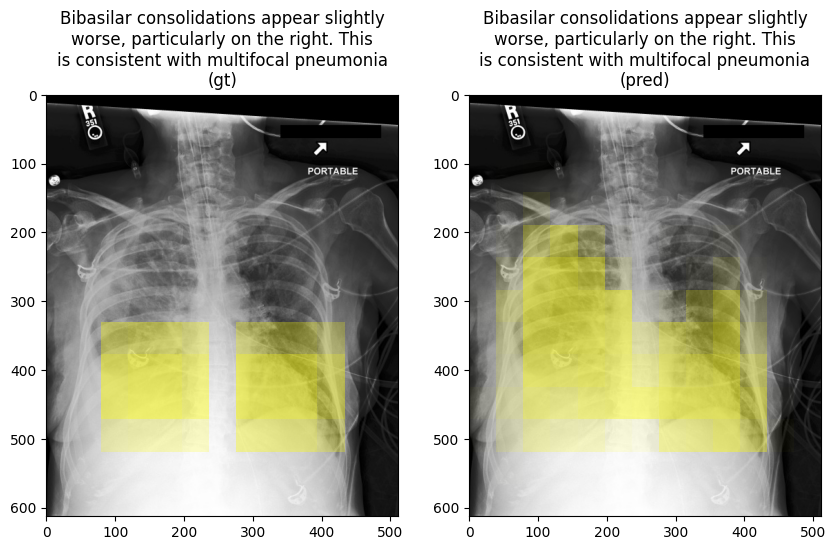

In [22]:
visualize_attention_maps(
    image_path=tmp['image_paths'][idx],
    figsize=(10,10),
    attention_factor=0.5,
    attention_maps=[
        tmp['gt_masks'][idx].reshape(13,13),
        tmp['pred_masks'][idx].reshape(13,13),
    ],
    titles=[
        f"{tmp['phrases'][idx]} (gt)",
        f"{tmp['phrases'][idx]} (pred)",
    ],
)

# 2) Phrase Grounding: DenseNet121 + CXRFE + Transformer Encoder

In [88]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240618_093614_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,TransformerEncoder,128,256,4,512,3)" \
--max_images_per_batch 100 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--mscxr_phrase2embedding_filepath \
"/mnt/workspace/pamessina/medvqa-workspace/cache/mimiccxr/mscxr_phrase2embedding(hash=36521,3206715123524916204).pkl" \
--eval_mscxr

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240618_093614_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,TransformerEncoder,128,256,4,512,3)
   max_images_per_batch: 100
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: /mnt/workspace/pamessina/medvqa-workspace/cache/mimiccxr/mscxr_phrase2embedding(hash=36521,3206715123524916204).pkl
   eval_chest_imagenome_gold: False
   eval_mscxr: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240618_093614_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,TransformerEncoder,128,256,4,512,3)/metadata.json
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of PhraseGrounder ...
MultiPurposeVisualModule()
  Initiali

In [90]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240619_114746_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,TransformerEncoder,128,256,2,512,2)" \
--max_images_per_batch 100 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--mscxr_phrase2embedding_filepath \
"/mnt/workspace/pamessina/medvqa-workspace/cache/mimiccxr/mscxr_phrase2embedding(hash=36521,3206715123524916204).pkl" \
--eval_mscxr

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240619_114746_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,TransformerEncoder,128,256,2,512,2)
   max_images_per_batch: 100
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: /mnt/workspace/pamessina/medvqa-workspace/cache/mimiccxr/mscxr_phrase2embedding(hash=36521,3206715123524916204).pkl
   eval_chest_imagenome_gold: False
   eval_mscxr: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240619_114746_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,TransformerEncoder,128,256,2,512,2)/metadata.json
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of PhraseGrounder ...
MultiPurposeVisualModule()
  Initiali

In [91]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240619_155740_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,TransformerEncoder,128,256,1,512,1)" \
--max_images_per_batch 100 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--mscxr_phrase2embedding_filepath \
"/mnt/workspace/pamessina/medvqa-workspace/cache/mimiccxr/mscxr_phrase2embedding(hash=36521,3206715123524916204).pkl" \
--eval_mscxr

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240619_155740_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,TransformerEncoder,128,256,1,512,1)
   max_images_per_batch: 100
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: /mnt/workspace/pamessina/medvqa-workspace/cache/mimiccxr/mscxr_phrase2embedding(hash=36521,3206715123524916204).pkl
   eval_chest_imagenome_gold: False
   eval_mscxr: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240619_155740_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,TransformerEncoder,128,256,1,512,1)/metadata.json
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of PhraseGrounder ...
MultiPurposeVisualModule()
  Initiali

In [96]:
tmp2 = load_pickle('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20240619_155740_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,TransformerEncoder,128,256,1,512,1)/mscxr_metrics.pkl')

In [177]:
tmp = tmp2

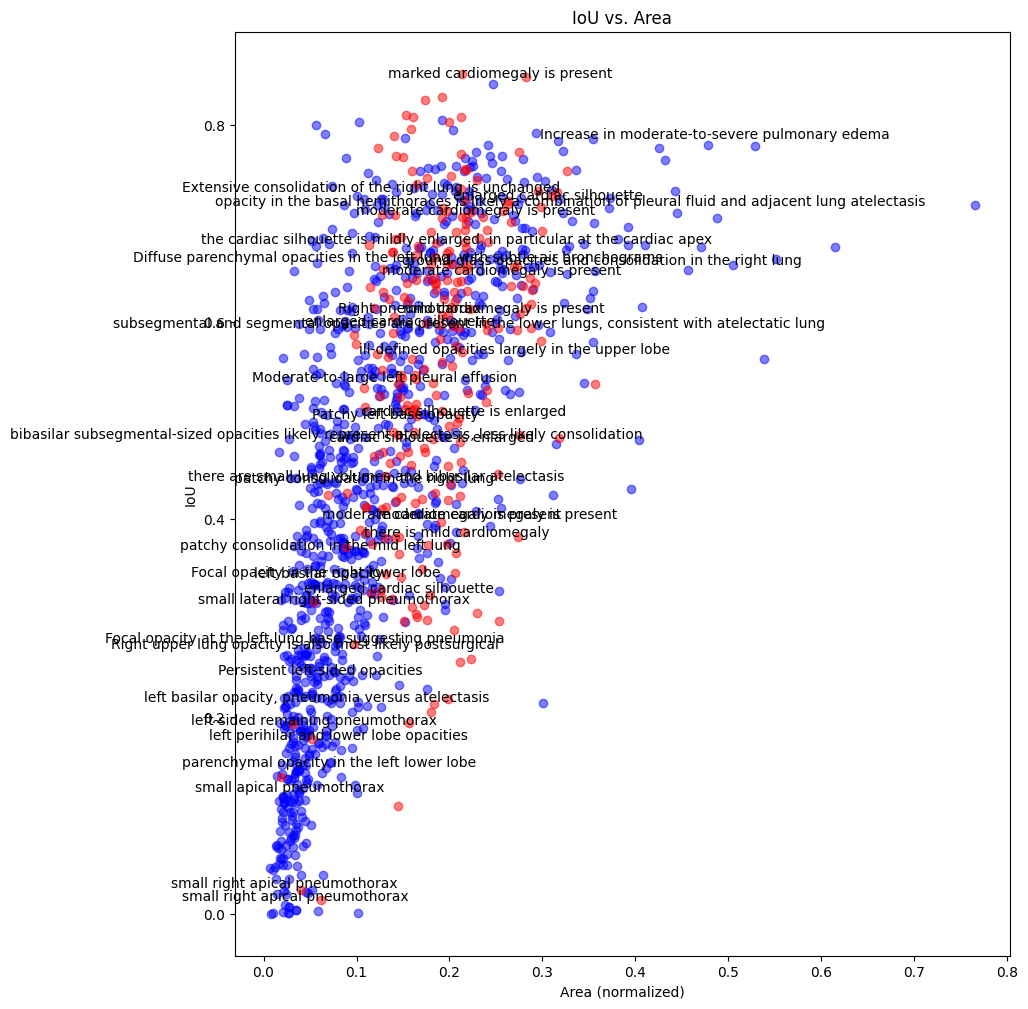

(IoU=0.841, area=0.247, idx=872) marked cardiomegaly is present
(IoU=0.779, area=0.478, idx=1137) Increase in moderate-to-severe pulmonary edema
(IoU=0.725, area=0.108, idx=1127) Extensive consolidation of the right lung is unchanged
(IoU=0.717, area=0.299, idx=805) enlarged cardiac silhouette
(IoU=0.711, area=0.322, idx=1027) opacity in the basal hemithoraces is likely a combination of pleural fluid and adjacent lung atelectasis
(IoU=0.702, area=0.220, idx=880) moderate cardiomegaly is present
(IoU=0.672, area=0.200, idx=1108) the cardiac silhouette is mildly enlarged, in particular at the cardiac apex
(IoU=0.655, area=0.137, idx=452) Diffuse parenchymal opacities in the left lung, with subtle air bronchograms
(IoU=0.651, area=0.357, idx=606) ground-glass opacities and consolidation in the right lung
(IoU=0.641, area=0.249, idx=585) moderate cardiomegaly is present
(IoU=0.603, area=0.149, idx=244) Right pneumothorax
(IoU=0.603, area=0.251, idx=1159) mild cardiomegaly is present
(IoU=0

In [178]:
plot_segmentation_mask_area_vs_iou(
    masks_array=tmp['gt_masks'],
    iou_array=tmp['ious'],
    normalize_area=True,
    sentences=tmp['phrases'],
    num_annotations=40,
    figsize=(10, 12),
    highlight_points_with_sentences_containing='cardiac',
)

==================== Bin 1 (0.000-0.213)


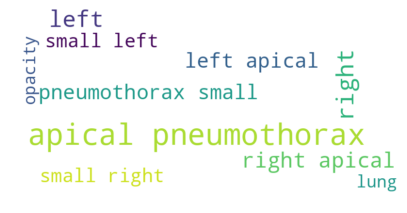

==================== Bin 2 (0.213-0.426)


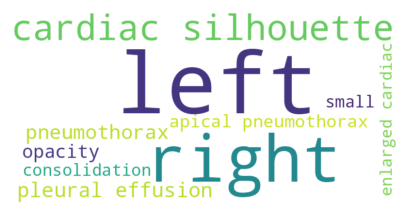

==================== Bin 3 (0.426-0.639)


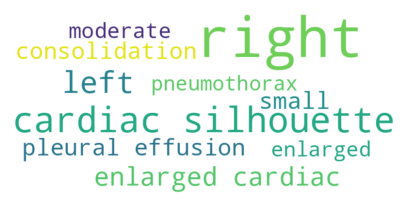

==================== Bin 4 (0.639-0.852)


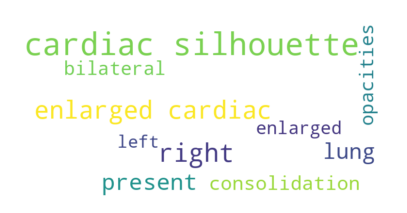

In [179]:
plot_wordclouds_per_bin(
    sentences=tmp['phrases'],
    scores=tmp['ious'],
    num_bins=4,
    figsize=(5,5),
    num_words=10
)

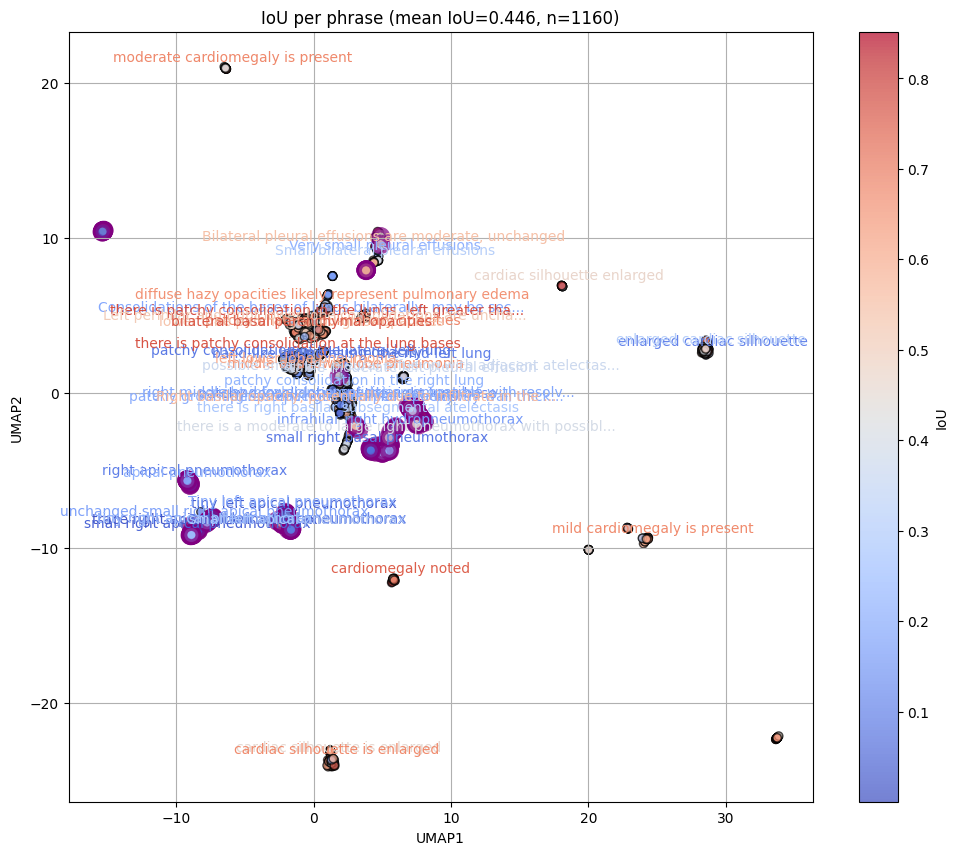

there is patchy consolidation in the lungs, left greater than right (0.773, idx=469)
there is patchy consolidation at the lung bases (0.763, idx=632)
bilateral basal parenchymal opacities (0.758, idx=73)
cardiomegaly noted (0.745, idx=915)
patchy bilateral pulmonary opacities (0.676, idx=282)
moderate cardiomegaly is present (0.673, idx=685)
cardiac silhouette is enlarged (0.670, idx=651)
mild cardiomegaly is present (0.670, idx=886)
middle and lower lobe pneumonia (0.662, idx=196)
diffuse hazy opacities likely represent pulmonary edema (0.653, idx=1021)
left lower lobe pneumonia (0.595, idx=115)
Right basilar opacity, potentially due to infiltrate in the proper clinical setting (0.564, idx=413)
Bilateral pleural effusions are moderate, unchanged (0.545, idx=723)
lower lobe patchy ground-glass opacities (0.535, idx=507)
Left perihilar and right lower lobe consolidations are unchanged.  (0.508, idx=542)
cardiac silhouette enlarged (0.468, idx=700)
cardiac silhouette is enlarged (0.454, 

In [181]:
plot_embeddings_sentences_and_scores(
    embeddings=[phrase2embedding[x] for x in tmp['phrases']],
    sentences=tmp['phrases'],
    scores=tmp['ious'],
    title='IoU per phrase',
    score_name='IoU',
    num_annotations=50,
    figsize=(12, 10),
    sentence_max_length=60,
    sample_more_from_low_scores=True,
    use_umap=True,
    highlight_points_with_sentences_containing='pneumothorax',
)

In [183]:
# i = -1
# idx = idxs[i]
# idx = 843
idx = 469
print(tmp['ious'][idx])
print()
print(tmp['image_paths'][idx])
print()
print(tmp['phrases'][idx])

dicom_id = tmp['image_paths'][idx].split('/')[-1].split('.')[0]

0.7725787162780762

/mnt/workspace/mimic-cxr-jpg/images-medium(512)/p12/p12593920/s57495887/543ddf75-b40274a0-27806ef2-e0231e20-9a290d39.jpg

there is patchy consolidation in the lungs, left greater than right


Found 3 rows for dicom_id 543ddf75-b40274a0-27806ef2-e0231e20-9a290d39
Image path: /mnt/data/mimic-cxr-jpg/images/p12/p12593920/s57495887/543ddf75-b40274a0-27806ef2-e0231e20-9a290d39.jpg
Label text: there is patchy consolidation in the lungs, left greater than right
Category name: Consolidation
x: 2065, y: 858, w: 707, h: 1241
Label text: there is patchy consolidation in the lungs, left greater than right
Category name: Consolidation
x: 509, y: 748, w: 305, h: 518
Label text: there is patchy consolidation in the lungs, left greater than right
Category name: Consolidation
x: 532, y: 1342, w: 661, h: 578


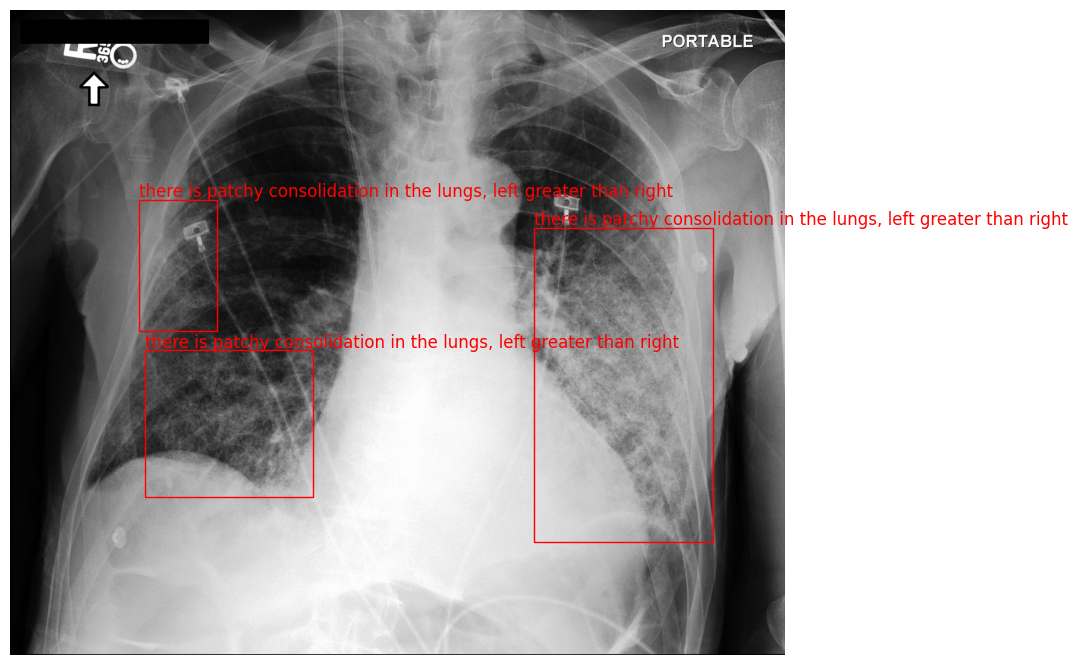

In [184]:
pgav.visualize_dicom_id(dicom_id)

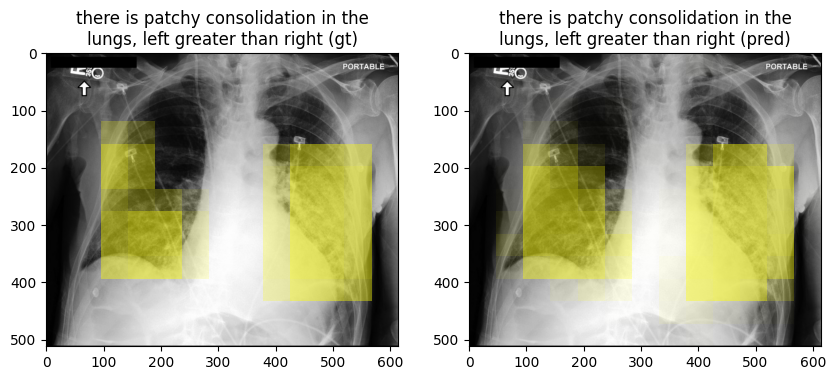

In [185]:
visualize_attention_maps(
    image_path=tmp['image_paths'][idx],
    figsize=(10,10),
    attention_factor=0.5,
    attention_maps=[
        tmp['gt_masks'][idx].reshape(13,13),
        tmp['pred_masks'][idx].reshape(13,13),
    ],
    titles=[
        f"{tmp['phrases'][idx]} (gt)",
        f"{tmp['phrases'][idx]} (pred)",
    ],
)